In [2]:
import pandas as pd
import numpy as np

In [82]:
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, mean_absolute_error, classification_report

In [25]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data"
data = pd.read_csv(url)
data.columns = ["Recency", "Frequency", "Monetary", "Time", "Target"]

In [26]:
print(data.isnull().sum())

Recency      0
Frequency    0
Monetary     0
Time         0
Target       0
dtype: int64


In [27]:
data = data.fillna(method='ffill')

C:\Users\Vishnu\AppData\Local\Temp\ipykernel_13952\917065080.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [28]:
print("Duplicates:", data.duplicated().sum())

Duplicates: 215


In [29]:
data = data.drop_duplicates()

In [30]:
print(data.dtypes)

Recency      int64
Frequency    int64
Monetary     int64
Time         int64
Target       int64
dtype: object


In [31]:
data['Recency'] = pd.to_numeric(data['Recency'], errors='coerce')
data['Frequency'] = pd.to_numeric(data['Frequency'], errors='coerce')
data['Monetary'] = pd.to_numeric(data['Monetary'], errors='coerce')
data['Time'] = pd.to_numeric(data['Time'], errors='coerce')
data['Target'] = data['Target'].astype(int)

In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data[['Recency', 'Frequency', 'Monetary', 'Time']] = scaler.fit_transform(data[['Recency', 'Frequency', 'Monetary', 'Time']])

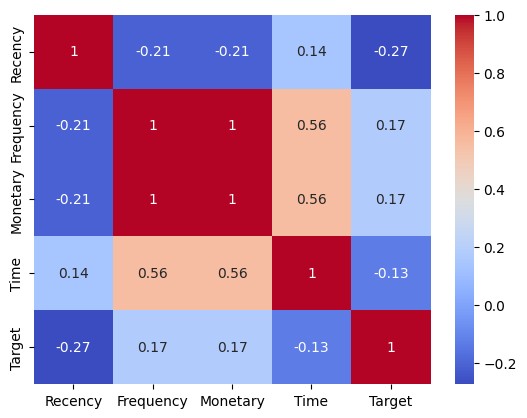

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.show()

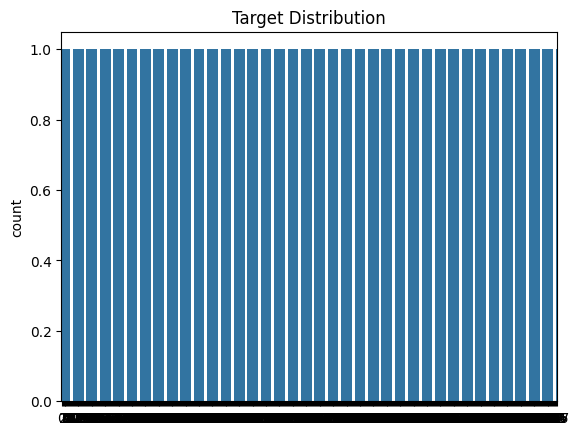

In [42]:
sns.countplot(data['Target'])
plt.title("Target Distribution")
plt.show()

In [43]:
X = data[['Recency', 'Frequency', 'Monetary', 'Time']]
y = data['Target']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
results = {}

In [47]:
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
train_time_rf = time.time() - start_time

In [48]:
start_time = time.time()
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
test_time_rf = time.time() - start_time

In [49]:
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_loss = 1 - rf_accuracy

In [50]:
results['Random Forest'] = {
    'Accuracy': rf_accuracy,
    'Loss': rf_loss,
    'Train Time': train_time_rf,
    'Test Time': test_time_rf
}

In [55]:
start_time = time.time()
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
train_time_nb = time.time() - start_time

In [61]:
start_time = time.time()
nb_pred = nb_model.predict(X_test)
nb_pred_proba = nb_model.predict_proba(X_test)[:, 1]
test_time_nb = time.time() - start_time

In [63]:
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_loss = log_loss(y_test, nb_pred_proba)

In [65]:
results['Naive Bayes'] = {
    'Accuracy': nb_accuracy,
    'Loss': nb_loss,
    'Train Time': train_time_nb,
    'Test Time': test_time_nb
}

In [67]:
ensemble_weights = [0.5, 0.5]
ensemble_proba = (ensemble_weights[0] * rf_pred_proba) + (ensemble_weights[1] * nb_pred_proba)
ensemble_pred = (ensemble_proba > 0.5).astype(int)

In [69]:
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
ensemble_log_loss = log_loss(y_test, ensemble_proba)
ensemble_mse = mean_squared_error(y_test, ensemble_proba)
ensemble_mae = mean_absolute_error(y_test, ensemble_proba)

In [76]:
results['Ensemble'] = {
    'Accuracy': ensemble_accuracy,
    'Loss': ensemble_log_loss,
    'MSE' : ensemble_mse,
    'MAE' : ensemble_mae,
    'Train Time': train_time_rf + train_time_nb,  # Combined training time
    'Test Time': test_time_rf + test_time_nb  # Combined testing time
}

In [78]:
print("Model Performance Summary:")
for model, metrics in results.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Model Performance Summary:

Random Forest:
  Accuracy: 0.6875
  Loss: 0.3125
  Train Time: 0.1812
  Test Time: 0.0273

Naive Bayes:
  Accuracy: 0.7125
  Loss: 0.7824
  Train Time: 0.0030
  Test Time: 0.0074

Ensemble:
  Accuracy: 0.7188
  Loss: 0.5615
  MSE: 0.1910
  MAE: 0.3557
  Train Time: 0.1842
  Test Time: 0.0347


In [84]:
print("\nClassification Report for Ensemble Model :")
print(classification_report(y_test, ensemble_pred))


Classification Report for Ensemble Model :
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       118
           1       0.45      0.36      0.40        42

    accuracy                           0.72       160
   macro avg       0.62      0.60      0.61       160
weighted avg       0.70      0.72      0.71       160

